In [1]:
import nltk
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gensim.downloader
import torch.nn as nn
from sklearn.model_selection import train_test_split
from collections import Counter
from torch.utils.data import Dataset, DataLoader

In [2]:
data = pd.read_csv('/kaggle/input/salary-prediction/Train_rev1.csv')
data.head(5)

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName
0,12612628,Engineering Systems Analyst,Engineering Systems Analyst Dorking Surrey Sal...,"Dorking, Surrey, Surrey",Dorking,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk
1,12612830,Stress Engineer Glasgow,Stress Engineer Glasgow Salary **** to **** We...,"Glasgow, Scotland, Scotland",Glasgow,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 35000/annum 25-35K,30000,cv-library.co.uk
2,12612844,Modelling and simulation analyst,Mathematical Modeller / Simulation Analyst / O...,"Hampshire, South East, South East",Hampshire,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 40000/annum 20-40K,30000,cv-library.co.uk
3,12613049,Engineering Systems Analyst / Mathematical Mod...,Engineering Systems Analyst / Mathematical Mod...,"Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 30000/annum 25K-30K negotiable,27500,cv-library.co.uk
4,12613647,"Pioneer, Miser Engineering Systems Analyst","Pioneer, Miser Engineering Systems Analyst Do...","Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk


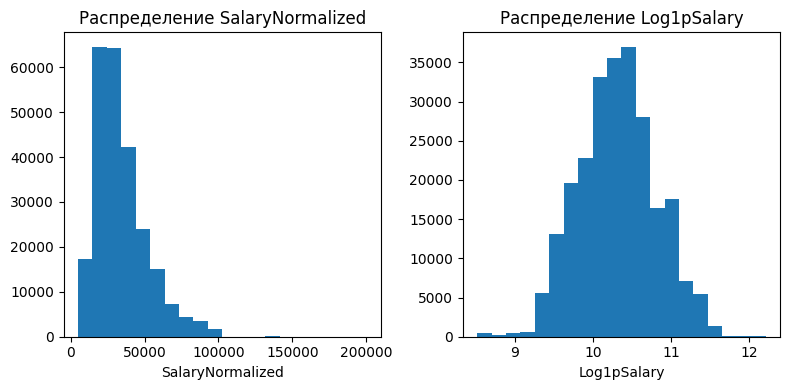

In [3]:
data['Log1pSalary'] = np.log1p(data['SalaryNormalized']).astype('float32')

plt.figure(figsize=[8, 4])

plt.subplot(1, 2, 1)
plt.hist(data["SalaryNormalized"], bins=20)
plt.title("Распределение SalaryNormalized")
plt.xlabel("SalaryNormalized")

plt.subplot(1, 2, 2)
plt.hist(data['Log1pSalary'], bins=20)
plt.title("Распределение Log1pSalary")
plt.xlabel("Log1pSalary")

plt.tight_layout()
plt.show()

In [4]:
text_columns = ['Title', 'FullDescription']
categorical_columns = ['LocationNormalized', 'ContractType', 'ContractTime', 'Company', 'Category']
target_column = 'Log1pSalary'

data[categorical_columns] = data[categorical_columns].fillna('NaN')
data.head(5)

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName,Log1pSalary
0,12612628,Engineering Systems Analyst,Engineering Systems Analyst Dorking Surrey Sal...,"Dorking, Surrey, Surrey",Dorking,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk,10.126671
1,12612830,Stress Engineer Glasgow,Stress Engineer Glasgow Salary **** to **** We...,"Glasgow, Scotland, Scotland",Glasgow,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 35000/annum 25-35K,30000,cv-library.co.uk,10.308986
2,12612844,Modelling and simulation analyst,Mathematical Modeller / Simulation Analyst / O...,"Hampshire, South East, South East",Hampshire,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 40000/annum 20-40K,30000,cv-library.co.uk,10.308986
3,12613049,Engineering Systems Analyst / Mathematical Mod...,Engineering Systems Analyst / Mathematical Mod...,"Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 30000/annum 25K-30K negotiable,27500,cv-library.co.uk,10.221977
4,12613647,"Pioneer, Miser Engineering Systems Analyst","Pioneer, Miser Engineering Systems Analyst Do...","Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk,10.126671


# Preprocess text data

In [5]:
tokenizer = nltk.tokenize.WordPunctTokenizer()
data['FullDescription'] = data['FullDescription'].apply(lambda x: ' '.join(tokenizer.tokenize(x.lower())))
data['Title'] = data['Title'].apply(lambda x: ' '.join(tokenizer.tokenize(str(x).lower())))

In [6]:
data.sample(5)

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName,Log1pSalary
161499,71189845,interim financial controller,the company robert half management resources a...,Birmingham West Midlands (County) West Midlands,UK,NaN,contract,Robert Half Management Resources,Accounting & Finance Jobs,350 - 450 per day,96000,totaljobs.com,11.472114
17183,66921662,software build engineer,"our client based in st neots , cambridgeshire ...","St Neots, Cambridgeshire, Cambridgeshire",St. Neots,NaN,permanent,Polytec Personnel Ltd,IT Jobs,25000 - 35000/annum,30000,cv-library.co.uk,10.308986
15732,66764400,material analyst,are you a materials analyst looking for a new ...,Worcestershire Redditch B97 4,Kingfisher Shopping Centre,NaN,permanent,JAM Recruitment,Engineering Jobs,28000.00 - 32000.00 GBP Annual,30000,jobg8.com,10.308986
66603,68713903,estimator industrial roofing & cladding – west...,about our client our client is a wellrespected...,West Midlands (County) West Midlands,UK,NaN,permanent,Just Building Envelopes,Trade & Construction Jobs,"From 35,000 to 40,000 per annum + Package",37500,totaljobs.com,10.532123
10084,66195364,software development team leader bristol,software development team leader (. net / mvc ...,Bristol,Bristol,NaN,permanent,NaN,IT Jobs,55000 - 65000 per annum,60000,theitjobboard.co.uk,11.002116


In [7]:
token_counter = Counter()
for title in data['Title']:
    token_counter.update(title.split(' '))
for desc in data['FullDescription']:
    token_counter.update(desc.split(' '))

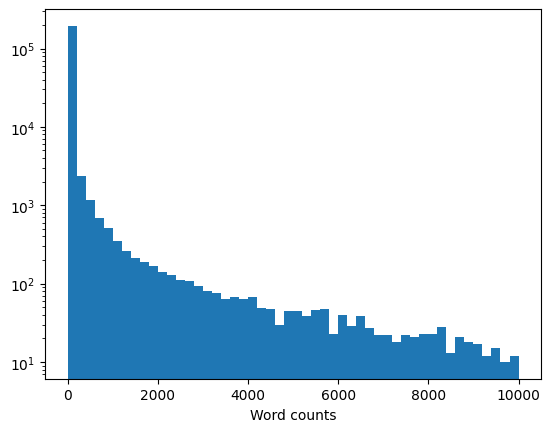

In [8]:
plt.hist(list(token_counter.values()), range=[0, 10**4], bins=50, log=True)
plt.xlabel("Word counts");

In [9]:
min_count = 10
tokens = [token for token, value in token_counter.items() if value >= min_count]
UNK, PAD = "UNK", "PAD"
tokens = [UNK, PAD] + tokens

In [10]:
token_to_index = {token: i for i, token in enumerate(tokens)}
UNK_IDX = token_to_index.get(UNK)
PAD_IDX = token_to_index.get(PAD)

In [11]:
def encode(sample):
    sequence = sample.split(' ')
    result = np.zeros(len(sequence))
    for i, word in enumerate(sequence):
        result[i] = token_to_index.get(word, UNK_IDX)
    return result

class SalaryDataset(Dataset):

    def __init__(self, titles, descriptions, labels):
        self.titles = titles
        self.descriptions = descriptions
        self.labels = labels

    def __len__(self):
        return len(self.titles)

    def __getitem__(self, idx):
        title = torch.tensor(encode(self.titles[idx]), dtype=torch.long)
        description = torch.tensor(encode(self.descriptions[idx]), dtype=torch.long)
        label = torch.tensor(self.labels[idx], dtype=torch.float32)

        return {'title': title, 'desc': description, 'label': label}

        
def make_collator(max_len=None):
    def collator_fn(batch):
        titles = [sample['title'] for sample in batch]        
        descs = [sample['desc'] for sample in batch]
        labels = [sample['label'] for sample in batch]

        title_max_len = max([len(title) for title in titles])
        desc_max_len = max([len(desc) for desc in descs])
        if max_len:
            title_max_len = min(title_max_len, max_len)
            desc_max_len = min(desc_max_len, max_len)

        padded_title = torch.full((len(batch), title_max_len), PAD_IDX, dtype=torch.long) 
        padded_desc = torch.full((len(batch), desc_max_len), PAD_IDX, dtype=torch.long)

        for i, (title, desc) in enumerate(zip(titles, descs)):
            title = title[:title_max_len]
            desc = desc[:desc_max_len]
            padded_title[i, :len(title)] = title
            padded_desc[i, :len(desc)] = desc

        return {'title': padded_title, 
                'desc': padded_desc, 
                'label': torch.tensor(labels, dtype=torch.float32)}
            
    return collator_fn

# Training part

In [12]:
data_train, data_val = train_test_split(data, test_size=0.2, random_state=42)
data_train.index = range(len(data_train))
data_val.index = range(len(data_val))

print("Train size = ", len(data_train))
print("Validation size = ", len(data_val))

Train size =  195814
Validation size =  48954


In [13]:
BATCH_SIZE = 16
collate_fn = make_collator()
train_dataset = SalaryDataset(data_train['Title'].values, data_train['FullDescription'].values, 
                              data_train['Log1pSalary'].values)
test_dataset = SalaryDataset(data_val['Title'].values, data_val['FullDescription'].values, 
                             data_val['Log1pSalary'].values)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

In [15]:
embeddings = gensim.downloader.load("glove-wiki-gigaword-100")

[==================================================] 100.0% 128.1/128.1MB downloaded


In [16]:
tokens_count = len(tokens)
embedding_dim = 100
embedding_matrix = np.zeros((tokens_count, embedding_dim))
for token in tokens:
    index = token_to_index.get(token)
    if token == 'PAD':
        embedding_matrix[index] = np.zeros(embedding_dim)
    elif token == 'UNK':
        embedding_matrix[index] = np.random.normal(size=(embedding_dim))
    elif token in embeddings:        
        embedding_matrix[index] = embeddings.get_vector(token)
    else:
        embedding_matrix[index] = np.random.normal(size=(embedding_dim))

In [17]:
embedding_matrix.shape

(34158, 100)

In [33]:
emb_layer = nn.Embedding(tokens_count, embedding_dim)
emb_layer.weight.data = torch.tensor(embedding_matrix, dtype=torch.float32)
emb_layer.weight.data

tensor([[ 0.2481,  0.7099,  1.1397,  ...,  1.3206, -0.9040,  1.9260],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.1817,  0.3117, -0.6379,  ..., -1.0454,  0.9588,  0.0640],
        ...,
        [ 0.5247,  0.5535,  0.9946,  ..., -1.4604,  0.7645, -0.3745],
        [-0.0770,  0.0020, -0.4239,  ...,  0.3645,  0.0202, -0.1122],
        [-0.1304,  1.3300, -0.2738,  ..., -0.2050,  0.2602,  0.4223]])

In [34]:
conv1 = nn.Conv1d(in_channels=embedding_dim, out_channels=32, kernel_size=3, padding=0)

In [35]:
r = emb_layer(next(iter(train_dataloader))['title'])
r.shape

torch.Size([16, 12, 100])

In [37]:
r1 = conv1(r.permute(0, 2, 1))
r1.shape

torch.Size([16, 32, 10])

In [39]:
relu = nn.ReLU()
r2 = relu(r1)
r2.shape

torch.Size([16, 32, 10])

In [40]:
r_pooled, _ = r2.max(dim=2)
r_pooled

tensor([[3.6772e-01, 5.5492e-01, 9.4256e-02, 4.1349e-01, 6.9642e-01, 5.1856e-01,
         3.8814e-02, 6.1812e-01, 3.0853e-01, 3.2692e-01, 5.9220e-01, 2.3425e-01,
         4.9214e-01, 3.9532e-01, 4.3218e-01, 2.0062e-01, 6.2315e-01, 7.2399e-01,
         1.0253e+00, 5.7606e-01, 2.4049e-01, 7.1554e-02, 6.2201e-01, 5.5129e-01,
         2.7318e-01, 3.5192e-01, 3.6489e-01, 4.2700e-01, 1.6602e-01, 2.3293e-01,
         3.1308e-01, 5.8736e-01],
        [6.6472e-02, 1.8451e-01, 1.7642e-02, 4.8083e-01, 5.1756e-01, 3.8828e-01,
         1.3114e-01, 1.5799e-01, 1.1906e-01, 5.0895e-02, 5.1736e-01, 5.1977e-01,
         4.1901e-01, 3.7872e-01, 3.5463e-01, 2.5868e-01, 1.7445e-01, 0.0000e+00,
         3.2265e-01, 1.8065e-01, 1.3315e-01, 0.0000e+00, 4.8657e-02, 5.1240e-01,
         1.4881e-01, 6.0688e-02, 3.7709e-01, 2.8712e-01, 1.2251e-01, 2.2885e-01,
         3.3077e-01, 5.4368e-02],
        [3.9369e-01, 7.4461e-01, 2.0762e-01, 3.7765e-01, 4.8654e-01, 2.1075e-01,
         4.5817e-01, 7.9632e-02, 2.4516e-

In [41]:
r_pooled.shape

torch.Size([16, 32])

In [42]:
linear = nn.Linear(in_features=32, out_features=1)
res = linear(r_pooled)

In [43]:
res

tensor([[-0.3344],
        [-0.1073],
        [-0.1969],
        [-0.1354],
        [-0.2824],
        [-0.2023],
        [-0.1317],
        [-0.2254],
        [-0.2499],
        [-0.2226],
        [-0.4675],
        [-0.4885],
        [-0.2745],
        [-0.2895],
        [-0.3330],
        [-0.2700]], grad_fn=<AddmmBackward0>)

In [44]:
res.shape

torch.Size([16, 1])